In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.layers.merge import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category= FutureWarning)
%matplotlib inline


In [2]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [3]:
model = color_net(4)

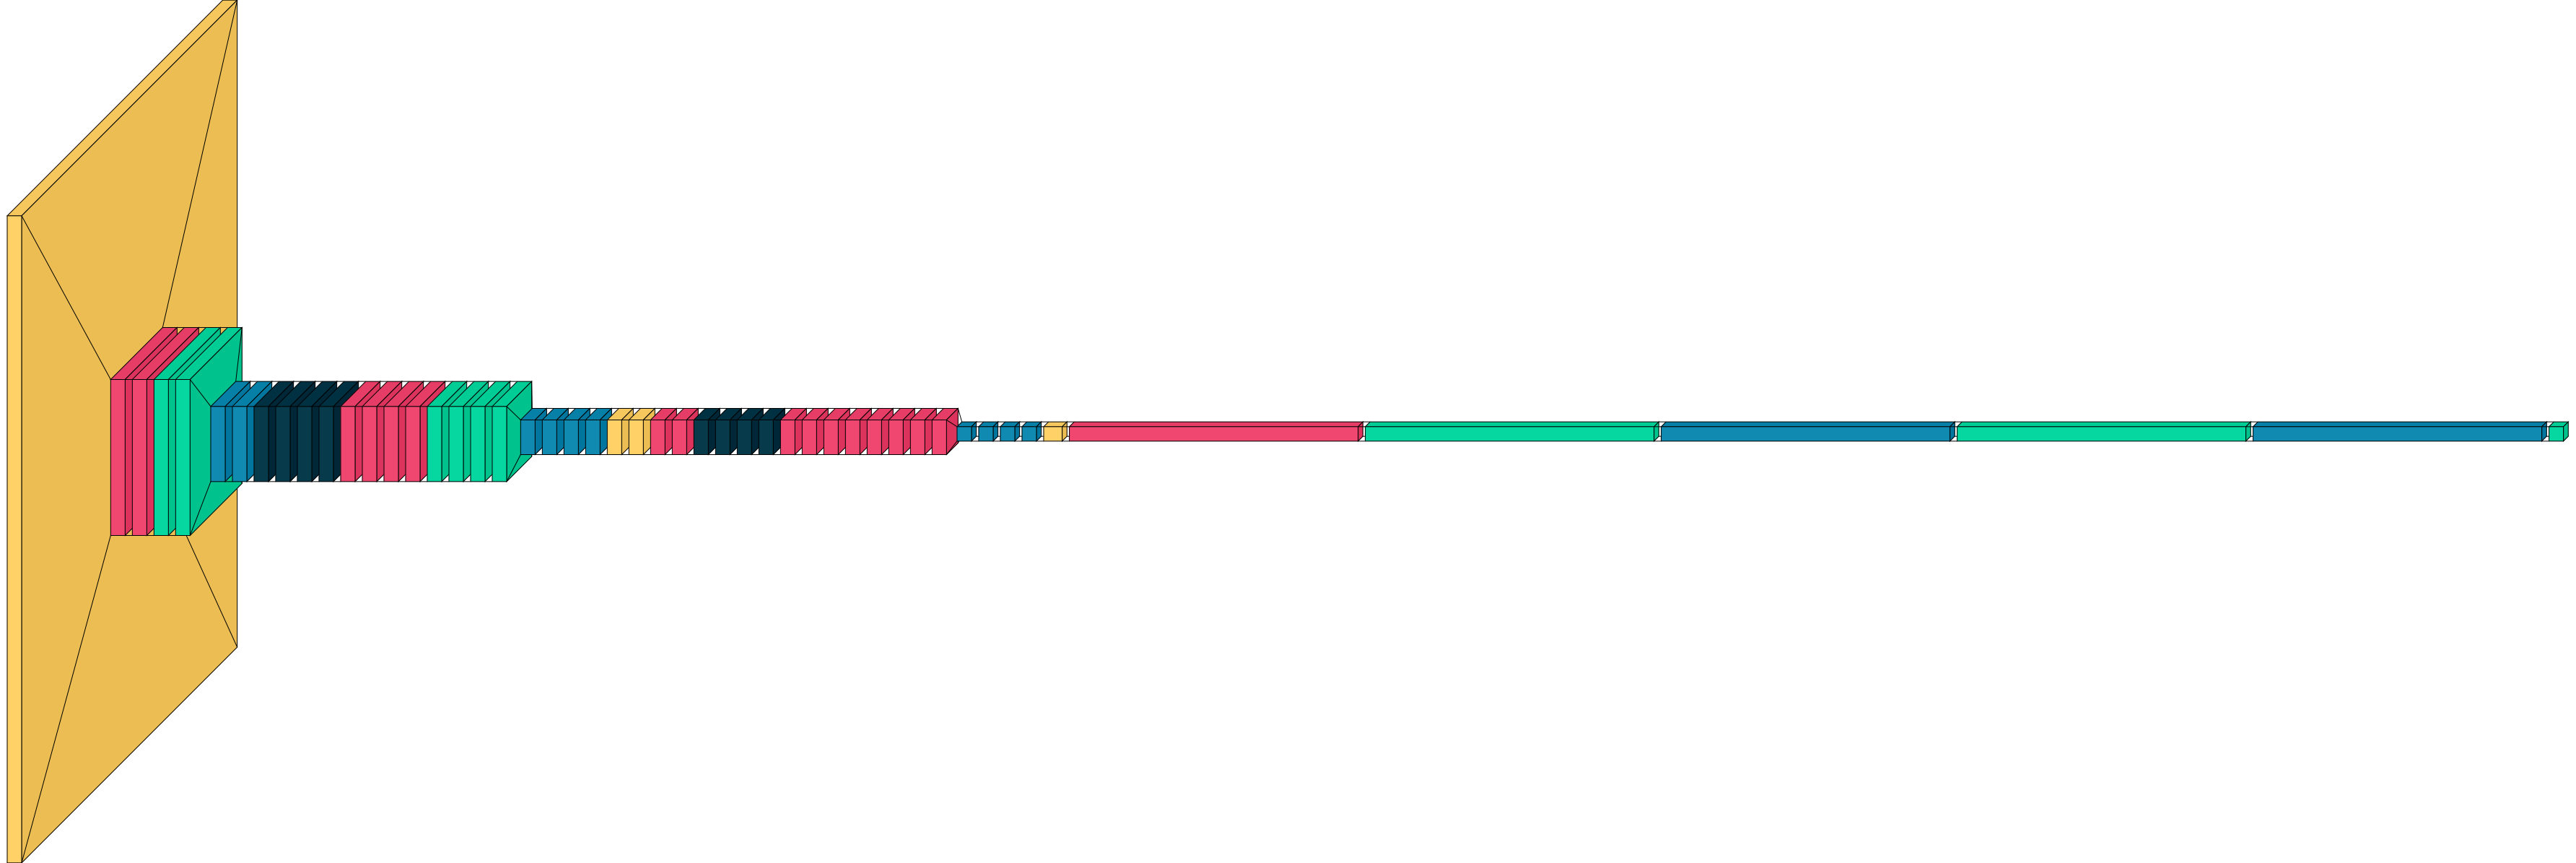

In [4]:
import visualkeras



visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)